## Deepwave FWI introductory lab 

This notebook contains a simple example to impliment FWI using Deepwave. Borrowed from [here](https://colab.research.google.com/drive/1PMO1rFAaibRjwjhBuyH3dLQ1sW5wfec_#scrollTo=MlTjxPNm-nNV)

In [1]:
import time
import torch
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import deepwave
%matplotlib inline

## setting the parameters 

    1- model parameters 
          - grid points (nx,nz) 
          - grid spacing (dx,dz)
          - num of dimension (1D, 2D, 3D)
     
    2- data parameter 
          - frequency 
          - number of sources 
          - number of receivers 
          - source spacing 
          - receiver spacing 
          - number of receiver per shot 

In [2]:
# Set parameters
freq = 25   
dx = 5.0
dt = 0.004 # 4ms
nz = 251
ny = 500
nt = int(2 / dt) # 2s
num_dims = 2
num_shots = 100
num_sources_per_shot = 1
num_receivers_per_shot = 250
source_spacing = 25.0
receiver_spacing = 10.0
device = torch.device('cuda:0')

## The aquisition set-up

 Create arrays containing the source and receiver locations
 
    x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions].
    
    x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]

In [3]:

x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing  

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

# When the sources and receivers are not in the surface, we also need to modify x_s[:, 0, 0] and x_r[0, :, 0]



## Create true source wavelet
    [nt, num_shots, num_sources_per_shot]

I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you can use whatever Tensor you want as the source wavelet. 

torch.Size([500, 100, 1])


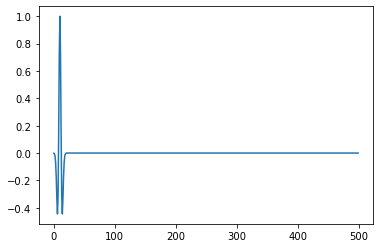

In [4]:


source_wavelet = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))
print(source_wavelet.shape)

plt.plot(source_wavelet[:,0,0])

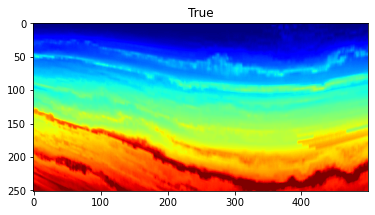

In [5]:
# Load the true model
model_true = (np.fromfile('SEAM_Vp_Elastic_N23900_chop.bin', np.float32)
              .reshape(ny, nz))
model_true = np.transpose(model_true) # I prefer having depth direction first
model_true = torch.Tensor(model_true) # Convert to a PyTorch Tensor


m_vmin, m_vmax = np.percentile(model_true.numpy(), [2,98]) 
plt.imshow(model_true, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');

## Forward modeling 

In [6]:
# Create 'true' data
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx) # create a propegator 

data_true = prop(source_wavelet.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [7]:
# Verify that the returned receiver amplitudes have shape
# [nt, num_shots, num_receivers_per_shot]
data_true.shape

torch.Size([500, 100, 250])

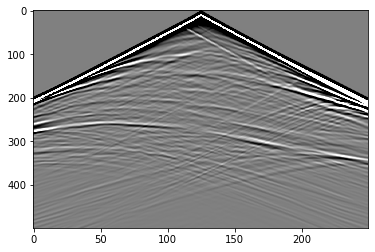

In [8]:
# Plot one shot gather
d_vmin, d_vmax = np.percentile(data_true[:,num_shots//2].cpu().numpy(), [2,98])

plt.imshow(data_true[:,num_shots//2].cpu().numpy(), aspect='auto',
           vmin=-d_vmax, vmax=d_vmax,cmap='gray')



## Create initial model for FWI 

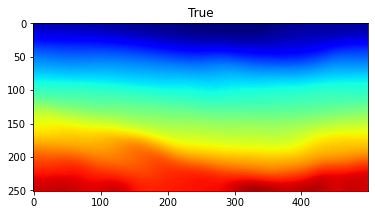

In [9]:
# Create initial guess model for inversion by smoothing the true model
model_init = scipy.ndimage.gaussian_filter(model_true.cpu().detach().numpy(),
                                           sigma=15)
model_init = torch.tensor(model_init)
# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

# plot the initial model 
plt.imshow(model_init, vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');

In [10]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
# I take the absolute value of the maximum and add a small positive value
# (1e-10) to ensure that the denominator is never zero
data_true_max, _ = data_true.max(dim=0, keepdim=True)
data_true_norm = data_true / (data_true_max.abs() + 1e-10)

In [11]:
# Set-up inversion
# I use different learning rates for the model and source amplitude inversions
# as they have very different scales. An alternative would be to rescale the
# model.
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([{'params': [model], 'lr': 10}])

Epoch: 0 Loss:  0.0006586639137822203


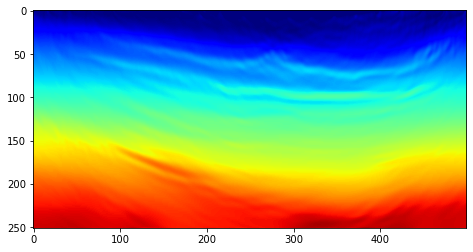

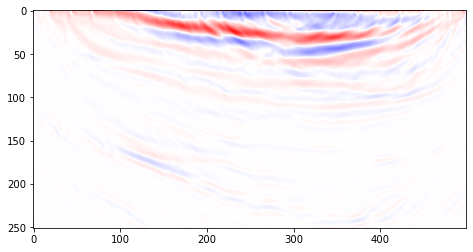

Epoch: 1 Loss:  0.0006307459916570224
Epoch: 2 Loss:  0.0006051459204172716
Epoch: 3 Loss:  0.0005862773905391805
Epoch: 4 Loss:  0.0005739008993259631
Epoch: 5 Loss:  0.0005646397621603683
Epoch: 6 Loss:  0.0005551908470806666
Epoch: 7 Loss:  0.0005443293921416625
Epoch: 8 Loss:  0.0005328817860572599
Epoch: 9 Loss:  0.0005221727551543154
Epoch: 10 Loss:  0.0005125711904838681


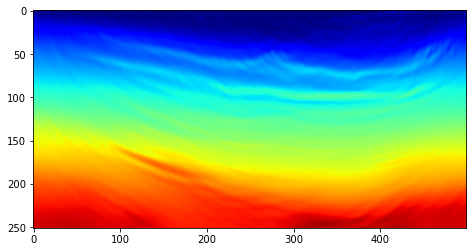

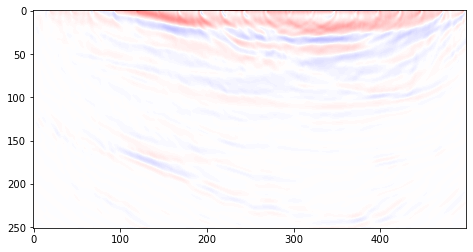

Epoch: 11 Loss:  0.0005035356589360163
Epoch: 12 Loss:  0.0004941641745972447
Epoch: 13 Loss:  0.0004841414847760461
Epoch: 14 Loss:  0.000473854313895572
Epoch: 15 Loss:  0.0004638136670109816
Epoch: 16 Loss:  0.0004544789553619921
Epoch: 17 Loss:  0.0004461427452042699
Epoch: 18 Loss:  0.0004389825990074314
Epoch: 19 Loss:  0.00043301511323079467
Epoch: 20 Loss:  0.0004279811182641424


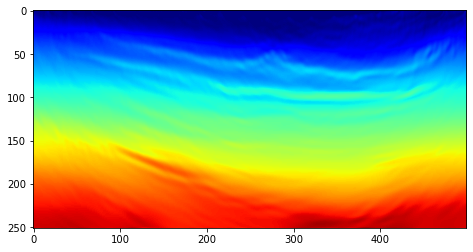

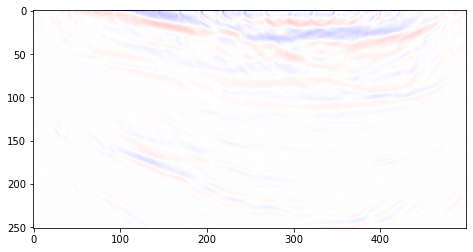

Epoch: 21 Loss:  0.0004233292565913871
Epoch: 22 Loss:  0.00041851758578559384
Epoch: 23 Loss:  0.0004131899186177179
Epoch: 24 Loss:  0.0004073497329954989
Epoch: 25 Loss:  0.00040122638165485114
Epoch: 26 Loss:  0.000395036353438627
Epoch: 27 Loss:  0.0003888497594743967
Epoch: 28 Loss:  0.0003827666077995673
Epoch: 29 Loss:  0.0003768642418435775
Runtime: 100.58760142326355


In [19]:
# Iterative inversion loop
t_start = time.time()
num_batches = 5 # split data into 10 batches for speed and reduced memory use
num_shots_per_batch = int(num_shots / num_batches)
num_epochs = 30 # Pass through the entire dataset 30 times
epoch_loss = []
for epoch in range(num_epochs):
  running_loss=0
  for it in range(num_batches):
    optimizer.zero_grad()
    prop = deepwave.scalar.Propagator({'vp': model}, dx)
    batch_src_wvl = source_wavelet[:,it::num_batches,].to(device)
    batch_data_true = data_true_norm[:,it::num_batches].to(device)
    batch_x_s = x_s[it::num_batches].to(device)
    batch_x_r = x_r[it::num_batches].to(device)
    data_pred = prop(batch_src_wvl, batch_x_s, batch_x_r, dt)
    data_pred_max, _ = data_pred.max(dim=0, keepdim=True)
    # Normalize amplitudes by dividing by the maximum amplitude of each receiver
    data_pred_norm = data_pred / (data_pred_max.abs() + 1e-10)
    loss = criterion(data_pred_norm, batch_data_true)
    running_loss += loss.item()
    loss.backward()
  epoch_loss.append(running_loss)      
  optimizer.step()
  print('Epoch:', epoch, 'Loss: ', running_loss)
  if epoch % 10 == 0:
    plt.figure(figsize=(8, 4))
    plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax,
               cmap='jet')
    plt.figure(figsize=(8, 4))
    plt.imshow(model.grad.cpu().detach().numpy(), 
               cmap='seismic',vmin=-1e-8,vmax=1e-8)
    plt.show()
t_end = time.time()
print('Runtime:', t_end - t_start)

Text(0.5, 0, 'iteration#')

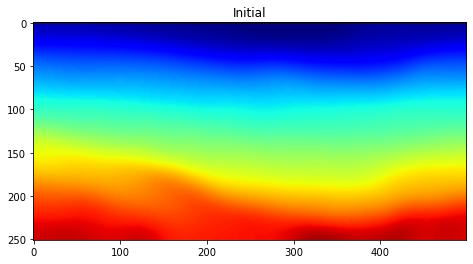

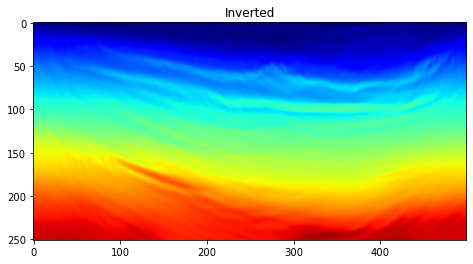

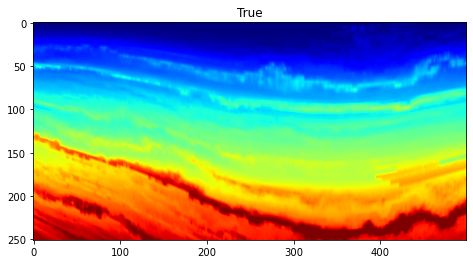

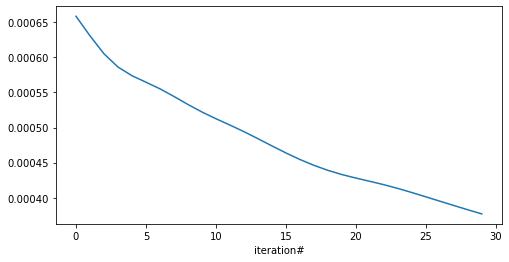

In [26]:
# Plot initial, inverted, and true models
figsize = (8, 4)
plt.figure(figsize=figsize)
plt.imshow(model_init.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Initial');
plt.figure(figsize=figsize)
plt.imshow(model.cpu().detach().numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('Inverted');
plt.figure(figsize=figsize)
plt.imshow(model_true.numpy(), vmin=m_vmin, vmax=m_vmax, cmap='jet')
plt.title('True');


# Plot convergence 
obj = np.array(epoch_loss)
plt.figure(figsize=(8,4))
plt.plot(np.arange(num_epochs),obj)
plt.xlabel('iteration#')